<img width="200" src="https://raw.githubusercontent.com/lukwies/mid-bootcamp-project/main/data/img/bikes.png">


# Bikesharing in Seoul / Exploration

### Sources

 * Data: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand
 * Image: https://global.chinadaily.com.cn/a/201801/25/WS5a69cab3a3106e7dcc136a6d.html


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yaml
import matplotlib.pyplot as plt
import sys
import os

#### Load YAML config file

In [2]:
with open('../params.yaml') as file:
    config = yaml.safe_load(file)

#### Read cleaned data

In [3]:
df = pd.read_csv(config['data']['csv_cleaned'])
df.head()

,date,month,hour,daytime,weekday,seasons,holiday,functioning_day,temperature,temperature_type,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,rented_bike_count
0,2017-12-01,12,0,Night,4,Winter,No,Yes,-5.2,Frost,37,2.2,2000,0.0,0.0,0.0,254
1,2017-12-01,12,1,Night,4,Winter,No,Yes,-5.5,Frost,38,0.8,2000,0.0,0.0,0.0,204
2,2017-12-01,12,2,Night,4,Winter,No,Yes,-6.0,Frost,39,1.0,2000,0.0,0.0,0.0,173
3,2017-12-01,12,3,Night,4,Winter,No,Yes,-6.2,Frost,40,0.9,2000,0.0,0.0,0.0,107
4,2017-12-01,12,4,Morning,4,Winter,No,Yes,-6.0,Frost,36,2.3,2000,0.0,0.0,0.0,78


In [4]:
def show_unique_values(df):
    for col in df.columns:
        print(f"COLUMN \x1b[1;31m{col}\x1b[0m ({df[col].dtype})")
        #if df[col].dtype == np.number:
        #    print(df[col].nunique())
        #else:
        print(df[col].unique())
        print()

In [5]:
show_unique_values(df)

COLUMN date (object)
['2017-12-01' '2017-12-02' '2017-12-03' '2017-12-04' '2017-12-05'
 '2017-12-06' '2017-12-07' '2017-12-08' '2017-12-09' '2017-12-10'
 '2017-12-11' '2017-12-12' '2017-12-13' '2017-12-14' '2017-12-15'
 '2017-12-16' '2017-12-17' '2017-12-18' '2017-12-19' '2017-12-20'
 '2017-12-21' '2017-12-22' '2017-12-23' '2017-12-24' '2017-12-25'
 '2017-12-26' '2017-12-27' '2017-12-28' '2017-12-29' '2017-12-30'
 '2017-12-31' '2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04'
 '2018-01-05' '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09'
 '2018-01-10' '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14'
 '2018-01-15' '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19'
 '2018-01-20' '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24'
 '2018-01-25' '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29'
 '2018-01-30' '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03'
 '2018-02-04' '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08'
 '2018-02-09' '2018-02-10' '2018-02-11' '2018-02-12' '2

#### Get description of numeric and categorical columns

In [6]:
display(df.describe().T)
display(df.describe(include=object).T)

,count,mean,std,min,25%,50%,75%,max
month,8760.0,6.526027,3.448048,1.0,4.00,7.00,10.00,12.00
hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
weekday,8760.0,3.002740,1.998056,0.0,1.00,3.00,5.00,6.00
temperature,8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
humidity,8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
wind_speed,8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
visibility,8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
solar_radiation,8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
rainfall,8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
snowfall,8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


,count,unique,top,freq
date,8760,365,2017-12-01,24
daytime,8760,5,Morning,2555
seasons,8760,4,Spring,2208
holiday,8760,2,No,8328
functioning_day,8760,2,Yes,8465
temperature_type,8760,5,Warm,2387


#### Detect and plot outliers

In [7]:
def get_outlier_count(data):
    df = data.copy()

    d = {}
    for col in df.select_dtypes(np.number).columns:
        
        iqr = np.percentile(df[col], 75) - np.percentile(df[col], 25)
        upper_limit = np.percentile(df[col],75) + 1.5*iqr
        lower_limit = np.percentile(df[col],25) - 1.5*iqr
        
        d[col] = df[(df[col] < lower_limit) | (df[col] > upper_limit)].shape[0]

    return d

In [8]:
out = get_outlier_count(df)
out

{'month': 0,
 'hour': 0,
 'weekday': 0,
 'temperature': 0,
 'humidity': 0,
 'wind_speed': 161,
 'visibility': 0,
 'solar_radiation': 641,
 'rainfall': 528,
 'snowfall': 443,
 'rented_bike_count': 158}

In [9]:
def plot_outliers(data):
    fig,ax = plt.subplots(2,4, figsize=(7,5))
    plt.tight_layout()
    ax[0,0].set_title('rented_bike_count')
    sns.boxplot(df['rented_bike_count'], ax=ax[0,0], color='red')
    ax[0,1].set_title('temperature')
    sns.boxplot(df['temperature'], ax=ax[0,1])
    ax[0,2].set_title('humidity')
    sns.boxplot(df['humidity'], ax=ax[0,2])
    ax[0,3].set_title('visibility')
    sns.boxplot(df['visibility'], ax=ax[0,3])
    ax[1,0].set_title('solar_radiation')
    sns.boxplot(df['solar_radiation'], ax=ax[1,0], color='red')
    ax[1,1].set_title('rainfall')
    sns.boxplot(df['rainfall'], ax=ax[1,1], color='red')
    ax[1,2].set_title('snowfall')
    sns.boxplot(df['snowfall'], ax=ax[1,2], color='red')
    plt.show()

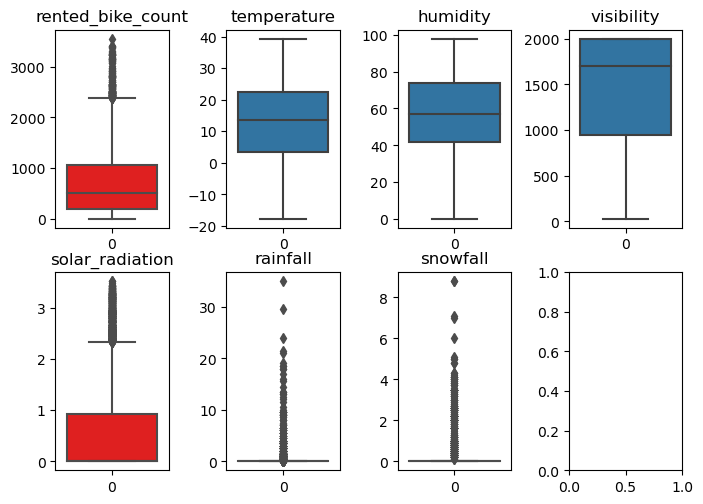

In [10]:
plot_outliers(df)

In [11]:
df['holiday'].value_counts()

No     8328
Yes     432
Name: holiday, dtype: int64

In [12]:
df['functioning_day'].value_counts()

Yes    8465
No      295
Name: functioning_day, dtype: int64

In [13]:
df.head()

,date,month,hour,daytime,weekday,seasons,holiday,functioning_day,temperature,temperature_type,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,rented_bike_count
0,2017-12-01,12,0,Night,4,Winter,No,Yes,-5.2,Frost,37,2.2,2000,0.0,0.0,0.0,254
1,2017-12-01,12,1,Night,4,Winter,No,Yes,-5.5,Frost,38,0.8,2000,0.0,0.0,0.0,204
2,2017-12-01,12,2,Night,4,Winter,No,Yes,-6.0,Frost,39,1.0,2000,0.0,0.0,0.0,173
3,2017-12-01,12,3,Night,4,Winter,No,Yes,-6.2,Frost,40,0.9,2000,0.0,0.0,0.0,107
4,2017-12-01,12,4,Morning,4,Winter,No,Yes,-6.0,Frost,36,2.3,2000,0.0,0.0,0.0,78


## Figure out how a certain time (season/month/day/hour) impacts the rental amount.

### Bike rentals by season

In [14]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_color = ['#ffff00', '#33cc33', '#ff6600', '#00aaff']

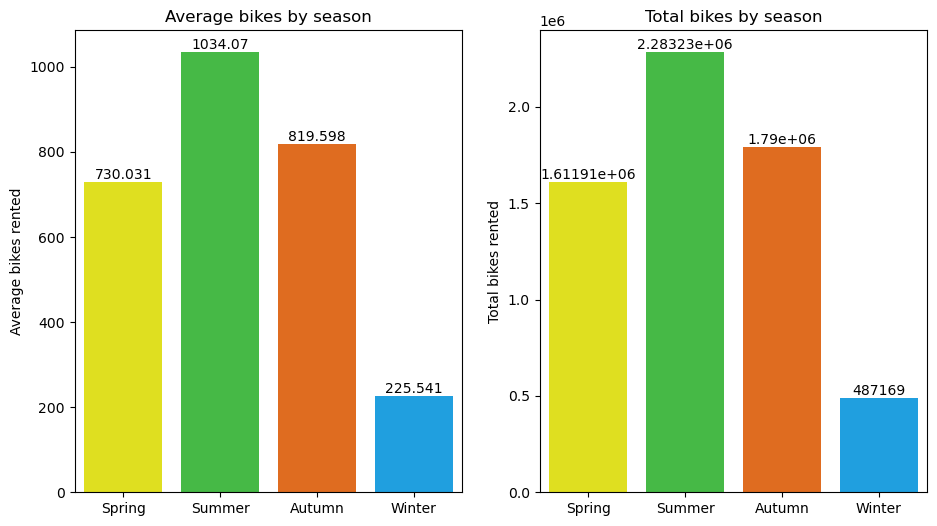

In [15]:
fig,ax = plt.subplots(1, 2, figsize=(11,6))

plot_df = df.groupby('seasons').agg({'rented_bike_count':'mean'}).reset_index()
sx = sns.barplot(data=plot_df, x='seasons', y='rented_bike_count', ax=ax[0], order=season_order, palette=season_color)
sx.bar_label(sx.containers[0], label_type='edge')
sx.set(ylabel='Average bikes rented', xlabel='', title='Average bikes by season')


plot_df = df.groupby('seasons').agg({'rented_bike_count':'sum'}).reset_index()
sx = sns.barplot(data=plot_df, x='seasons', y='rented_bike_count', ax=ax[1], order=season_order, palette=season_color)
sx.bar_label(sx.containers[0], label_type='edge')
sx.set(ylabel='Total bikes rented', xlabel='', title='Total bikes by season')

plt.savefig("../plots/bikes_by_season.png")
plt.show()


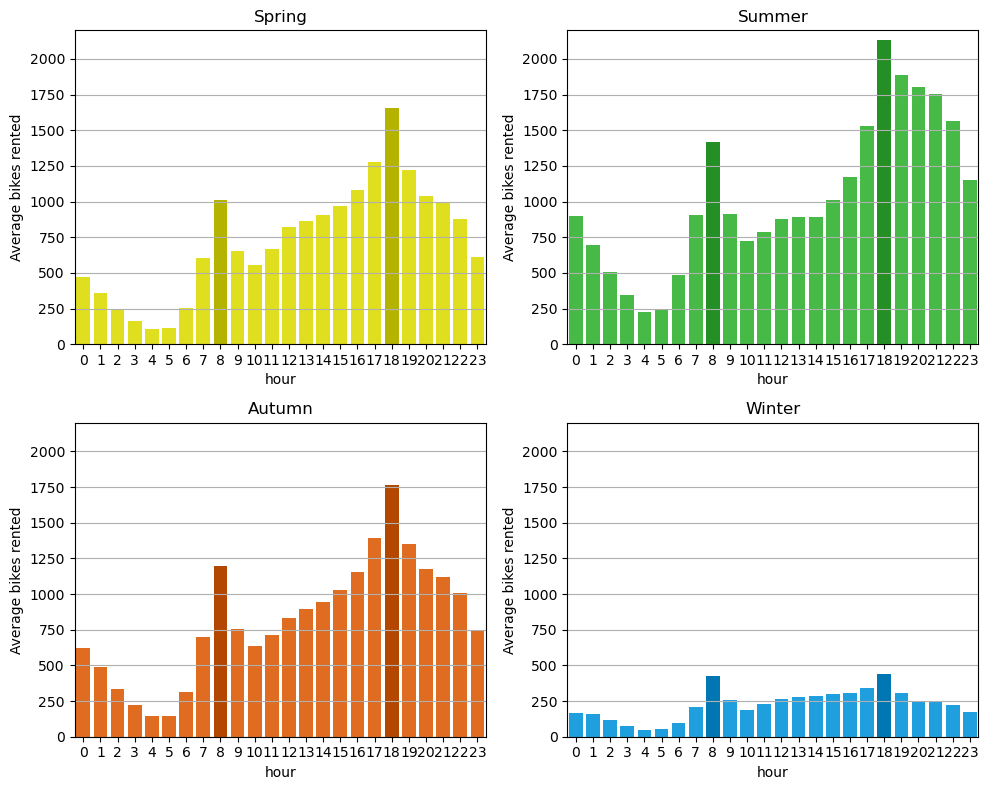

In [16]:
plot_df = df.pivot_table(index='hour', values=['rented_bike_count'], columns='seasons').reset_index()
fig,ax = plt.subplots(2, 2, figsize=(10,8))

sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Spring'], color=season_color[0], ax=ax[0,0])
ax[0,0].set(ylim=(0, 2200), title='Spring', ylabel='Average bikes rented')
ax[0,0].patches[8].set_facecolor('#b3b300')
ax[0,0].patches[18].set_facecolor('#b3b300')
ax[0,0].grid(axis='y')

sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Summer'], color=season_color[1], ax=ax[0,1])
ax[0,1].set(ylim=(0, 2200), title='Summer', ylabel='Average bikes rented')
ax[0,1].patches[8].set_facecolor('#248f24')
ax[0,1].patches[18].set_facecolor('#248f24')
ax[0,1].grid(axis='y')


sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Autumn'], color=season_color[2], ax=ax[1,0])
ax[1,0].set(ylim=(0, 2200), title='Autumn', ylabel='Average bikes rented')
ax[1,0].patches[8].set_facecolor('#b34700')
ax[1,0].patches[18].set_facecolor('#b34700')
ax[1,0].grid(axis='y')


sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Winter'], color=season_color[3], ax=ax[1,1])
ax[1,1].set(ylim=(0, 2200), title='Winter', ylabel='Average bikes rented')
ax[1,1].patches[8].set_facecolor('#0077b3')
ax[1,1].patches[18].set_facecolor('#0077b3')
ax[1,1].grid(axis='y')


plt.tight_layout()
plt.savefig("../plots/bikes_by_season_and_hour.png")
plt.show()


### Bike rentals by month

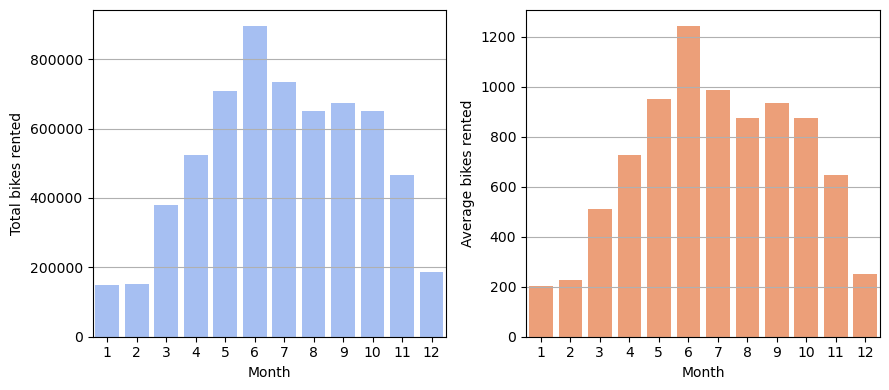

In [17]:
fig,ax = plt.subplots(1, 2, figsize=(9,4))

plot_df = df.groupby('month').agg({'rented_bike_count':'mean'}).reset_index()
sx = sns.barplot(data=plot_df, x='month', y='rented_bike_count', color='#ff9966', ax=ax[1])
sx.set(ylabel='Average bikes rented', xlabel='Month')
sx.grid(axis='y')

plot_df = df.groupby('month').agg({'rented_bike_count':'sum'}).reset_index()
sx = sns.barplot(data=plot_df, x='month', y='rented_bike_count', color='#99bbff', ax=ax[0])
sx.set(ylabel='Total bikes rented', xlabel='Month')
sx.grid(axis='y')


plt.tight_layout()
plt.savefig("../plots/bikes_by_month.png")
plt.show()


### Bike rentals by weekday

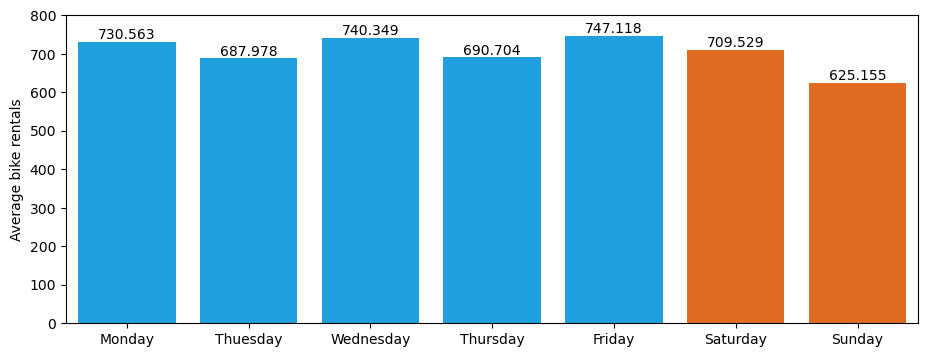

In [18]:
plot_df = df.groupby('weekday').agg({'rented_bike_count':'mean'}).reset_index()
plot_df['weekday'] = plot_df['weekday'].replace({0:'Monday', 1:'Thuesday', 2:'Wednesday',
                                                 3:'Thursday', 4:'Friday', 5:'Saturday',
                                                 6:'Sunday'})
wd_colors = ['#00aaff', '#00aaff', '#00aaff', '#00aaff', '#00aaff', '#ff6600', '#ff6600']

fig,ax = plt.subplots(figsize=(11,4))
sx = sns.barplot(data=plot_df, x='weekday', y='rented_bike_count', ax=ax, palette=wd_colors)
sx.bar_label(sx.containers[0], label_type='edge')
sx.set(xlabel='', ylabel='Average bike rentals', ylim=(0,800))

plt.savefig('../plots/bikes_by_weekday.png')
plt.show()


### Bike rentals on holidays / weekends

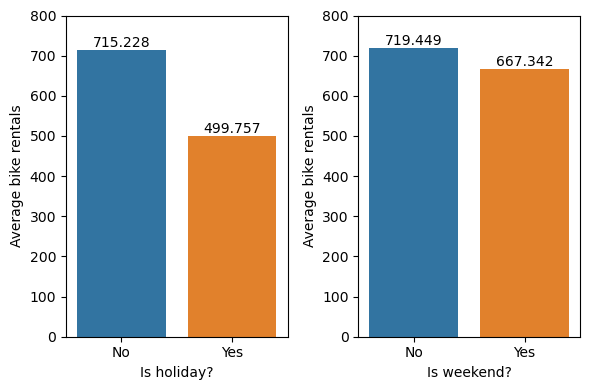

In [19]:
plot_h_df = df.groupby('holiday').agg({'rented_bike_count':'mean'}).reset_index()
plot_w_df = df.copy()
plot_w_df['weekend'] = df['weekday'].apply(lambda d: 'Yes' if d > 4 else 'No')
plot_w_df = plot_w_df.groupby('weekend').agg({'rented_bike_count':'mean'}).reset_index()

fig,ax = plt.subplots(1, 2, figsize=(6,4))

sx = sns.barplot(data=plot_h_df, x='holiday', y='rented_bike_count', ax=ax[0])
sx.bar_label(sx.containers[0], label_type='edge')
sx.set(xlabel='Is holiday?', ylabel='Average bike rentals', ylim=(0,800))

sx = sns.barplot(data=plot_w_df, x='weekend', y='rented_bike_count', ax=ax[1])
sx.set(xlabel='Is weekend?', ylabel='Average bike rentals', ylim=(0,800))
sx.bar_label(sx.containers[0], label_type='edge')

plt.tight_layout()
plt.savefig('../plots/bikes_by_holiday.png')
plt.show()


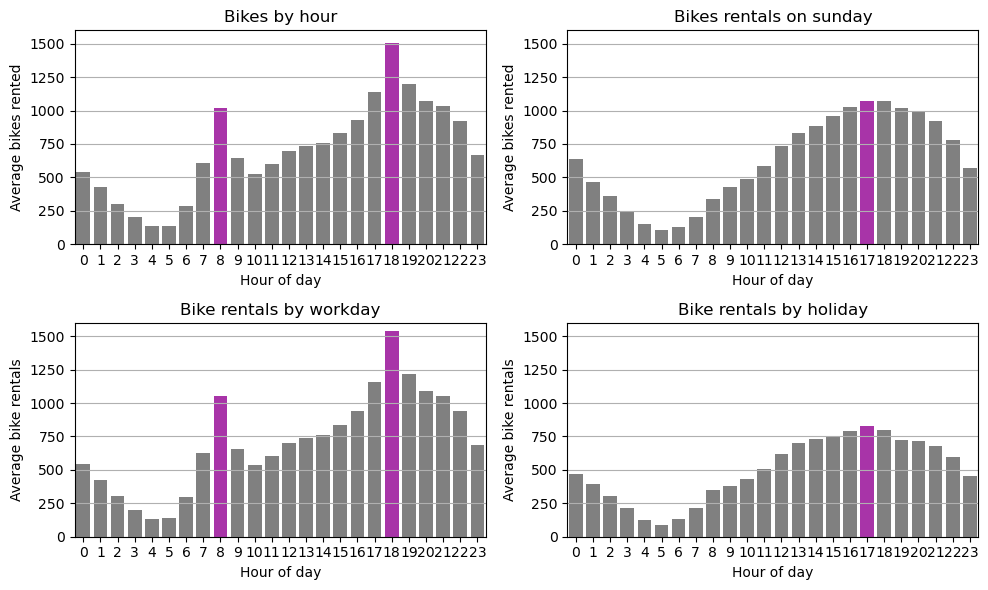

In [20]:
plot_we_df  = df[df['holiday'] == 'Yes'].groupby('hour').agg({'rented_bike_count':'mean'}).reset_index()
plot_wd_df  = df[df['holiday'] == 'No'].groupby('hour').agg({'rented_bike_count':'mean'}).reset_index()
plot_sun_df = df[df['weekday'] == 6].groupby('hour').agg({'rented_bike_count':'mean'}).reset_index()
plot_all_df = df.groupby('hour').agg({'rented_bike_count':'mean'}).reset_index()

fig,ax = plt.subplots(2,2, figsize=(10,6))

sx = sns.barplot(data=plot_all_df, x='hour', y='rented_bike_count', ax=ax[0,0], color='grey')
sx.set(ylabel='Average bikes rented', xlabel='Hour of day', title='Bikes by hour', ylim=(0,1600))
sx.grid(axis='y')
sx.patches[8].set_facecolor('#a834a8')  
sx.patches[18].set_facecolor('#a834a8')  

sx = sns.barplot(data=plot_wd_df, y='rented_bike_count', x='hour', ax=ax[1,0], color='grey')
sx.set(title='Bike rentals by workday', ylabel='Average bike rentals', xlabel='Hour of day', ylim=(0,1600))
sx.grid(axis='y')
sx.patches[8].set_facecolor('#a834a8')
sx.patches[18].set_facecolor('#a834a8') 

sx = sns.barplot(data=plot_sun_df, x='hour', y='rented_bike_count', ax=ax[0,1], color='grey')
sx.set(ylabel='Average bikes rented', xlabel='Hour of day', title='Bikes rentals on sunday', ylim=(0,1600))
sx.grid(axis='y')
sx.patches[17].set_facecolor('#a834a8')  

sx = sns.barplot(data=plot_we_df, y='rented_bike_count', x='hour', ax=ax[1,1], color='grey')
sx.set(title='Bike rentals by holiday', ylabel='Average bike rentals', xlabel='Hour of day', ylim=(0,1600))
sx.grid(axis='y')
sx.patches[17].set_facecolor('#a834a8')

plt.tight_layout()
plt.savefig('../plots/bikes_by_hour_and_holiday.png')
plt.show()


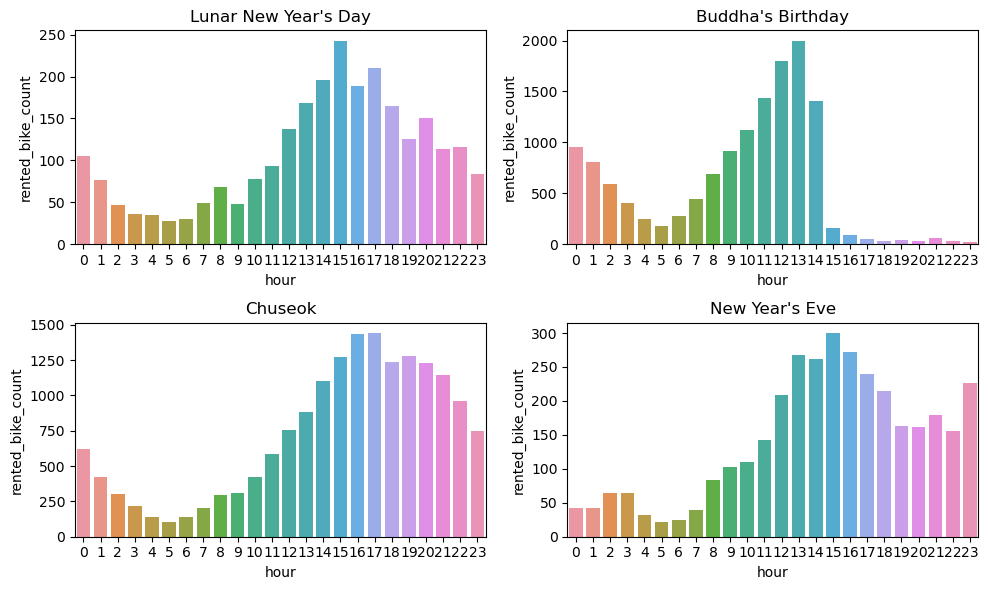

In [21]:
fig,ax = plt.subplots(2, 2, figsize=(10,6))

buddha = df[df['date']=='2018-05-22']
sx = sns.barplot(data=df[df['date']=='2018-02-16'], y='rented_bike_count', x='hour', ax=ax[0,0])
sx.set(title="Lunar New Year's Day")
sx = sns.barplot(data=df[df['date']=='2018-05-22'], y='rented_bike_count', x='hour', ax=ax[0,1])
sx.set(title="Buddha's Birthday")
sx = sns.barplot(data=df[df['date']=='2018-09-24'], y='rented_bike_count', x='hour', ax=ax[1,0])
sx.set(title="Chuseok")
sx = sns.barplot(data=df[df['date']=='2017-12-31'], y='rented_bike_count', x='hour', ax=ax[1,1])
sx.set(title="New Year's Eve")



plt.tight_layout()
plt.savefig('../plots/bikes_by_special_day.png')
plt.show()


### Bike rentals by daytime

In [22]:
daytime_order = ['Morning','Noon', 'Afternoon', 'Evening', 'Night']

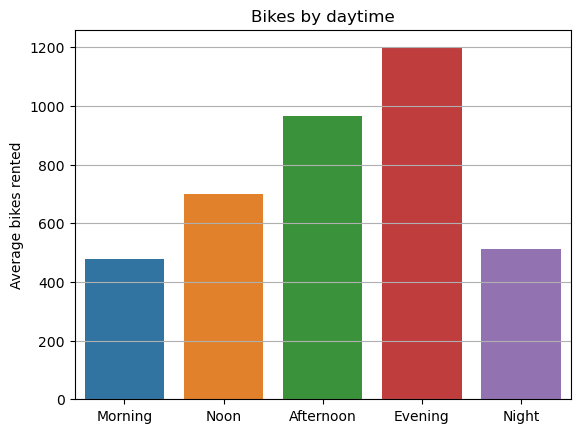

In [23]:
plot_df = df.groupby('daytime').agg({'rented_bike_count':'mean'}).reset_index()
ax = sns.barplot(data=plot_df, x='daytime', y='rented_bike_count', order=daytime_order)
ax.set(ylabel='Average bikes rented', xlabel='', title='Bikes by daytime')
ax.grid(axis='y')

plt.savefig('../plots/bikes_by_daytime.png')
plt.show()

## Figure out how the weather impacts the rental amount.

### Bike rentals by temperature

In [24]:
temptype_order = ['Frost', 'Cold', 'Mild', 'Warm', 'Hot']
temptype_color = ['#ccf5ff', '#1ad1ff', '#ffff80', '#ffa64d', '#ff471a']

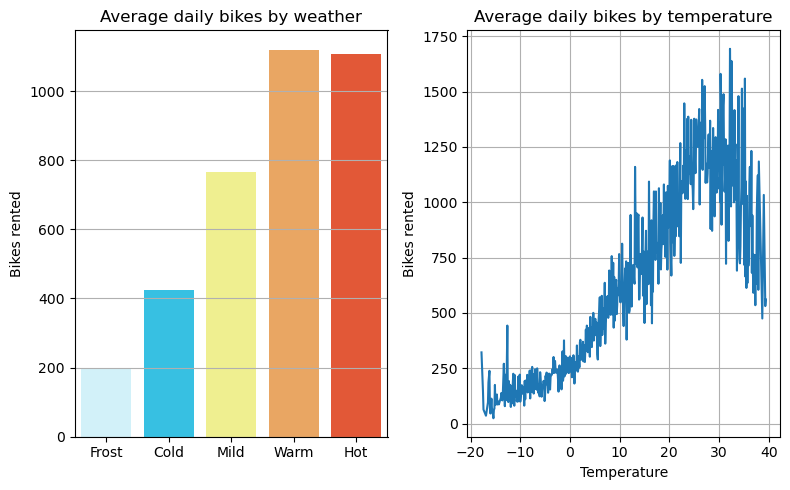

In [25]:
plot_w_df = df.groupby('temperature_type').agg({'rented_bike_count':'mean'}).reset_index()
plot_t_df = df.groupby('temperature').agg({'rented_bike_count':'mean'}).reset_index()

fig,ax = plt.subplots(1, 2, figsize=(8,5))

sax = sns.barplot(data=plot_w_df, x='temperature_type', y='rented_bike_count',
                 order=temptype_order, palette=temptype_color, ax=ax[0])
sax.set(ylabel='Bikes rented', xlabel='', title='Average daily bikes by weather')
sax.grid(axis='y')

sax = sns.lineplot(data=plot_t_df, y='rented_bike_count', x='temperature', ax=ax[1])
sax.set(ylabel='Bikes rented', xlabel='Temperature', title='Average daily bikes by temperature')
sax.grid()

plt.tight_layout()
plt.savefig('../plots/bikes_by_temperature.png')
plt.show()

### Bike rentals by rainfall/snowfall

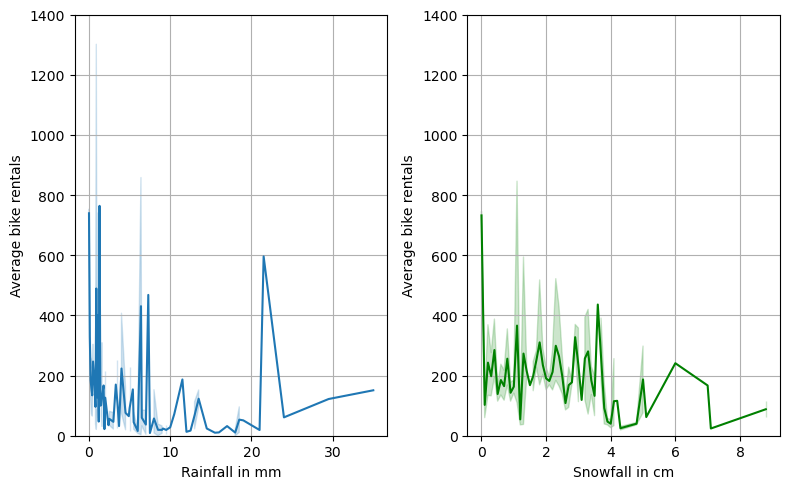

In [26]:
fig,ax = plt.subplots(1, 2, figsize=(8,5))
sax = sns.lineplot(data=df, y='rented_bike_count', x='rainfall', ax=ax[0])
sax.grid()
sax.set(ylim=(0,1400), ylabel='Average bike rentals', xlabel='Rainfall in mm')

sax = sns.lineplot(data=df, y='rented_bike_count', x='snowfall', ax=ax[1], color='green')
sax.grid()
sax.set(ylim=(0,1400), ylabel='Average bike rentals', xlabel='Snowfall in cm')

plt.tight_layout()
plt.savefig('../plots/bikes_by_rainfall.png')
plt.show()

### Bike rentals by wind strength

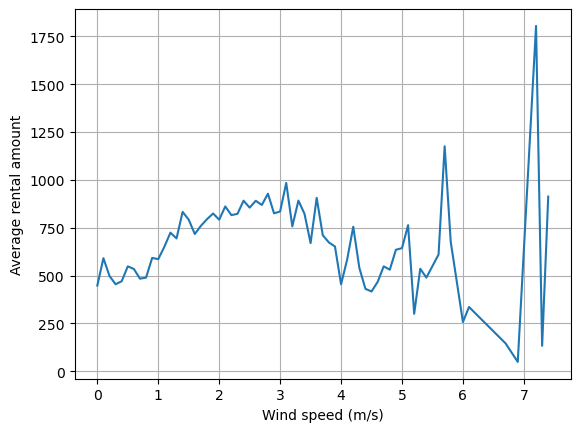

In [27]:
plot_df = df.groupby('wind_speed').agg({'rented_bike_count':'mean'}).reset_index()
sax = sns.lineplot(data=plot_df, y='rented_bike_count', x='wind_speed')
sax.set(ylabel='Average rental amount', xlabel='Wind speed (m/s)')
sax.grid()

plt.savefig('../plots/bikes_by_windstrength.png')
plt.show()

### Bike rentals by solar radiation

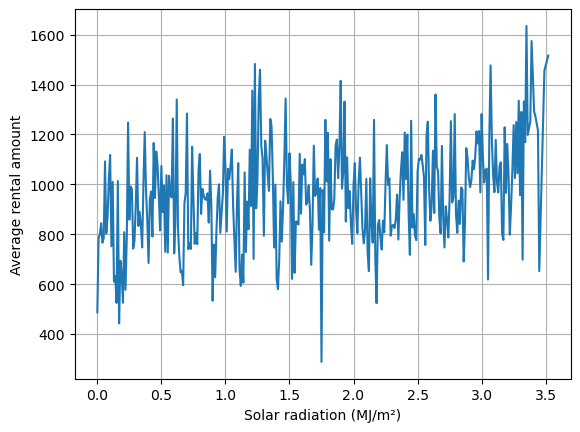

In [28]:
plot_df = df.groupby('solar_radiation').agg({'rented_bike_count':'mean'})
sax = sns.lineplot(data=plot_df, y='rented_bike_count', x='solar_radiation')
sax.set(ylabel='Average rental amount', xlabel='Solar radiation (MJ/m²)')
sax.grid()

plt.savefig('../plots/bikes_by_solar_radiation.png')
plt.show()

### Show correlation between numerical columns

<AxesSubplot:>

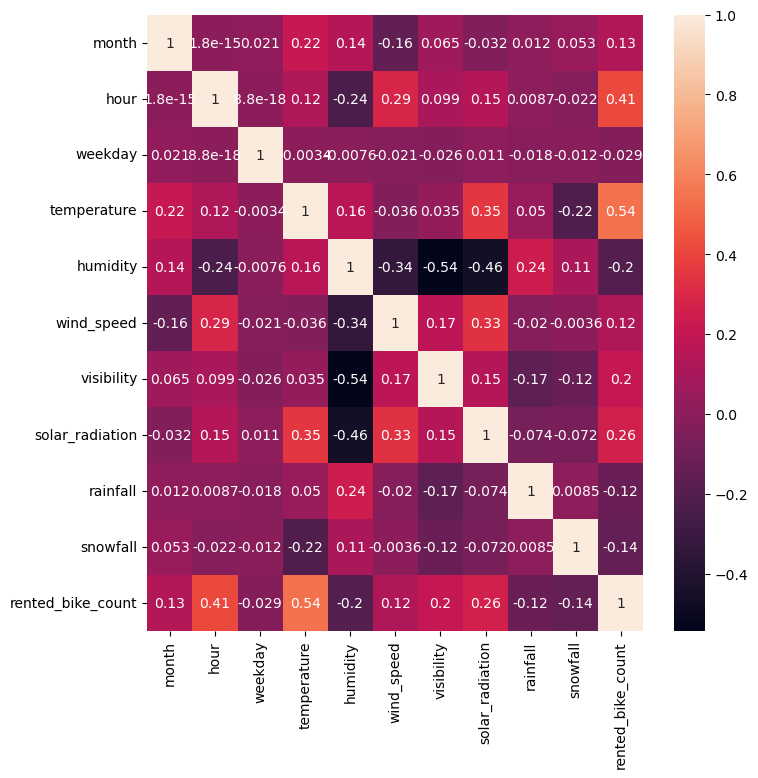

In [29]:
fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(df.corr(), annot=True)